### ***Libraries import***

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### ***Data loading***

In [38]:
df = pd.read_csv('/kaggle/input/cicids2017-improved-preprocessed/CICIDS2017_improved-preprocessed.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.shape

(1715326, 49)

### ***Data splitting***

In [39]:
df_benign = df[df['Label'] == 0]
df_anomalous = df[df['Label'] == 1]

In [40]:
X_train, X_test = train_test_split(df_benign, test_size=0.15, random_state=42)
X_train.drop('Label', axis=1, inplace=True)

X_train, X_val = train_test_split(X_train, test_size=0.15, random_state=42)

X_test = pd.concat([X_test, df_anomalous]).sample(frac=1.0)

print('Training dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)
print('Validation dataset shape: ', X_val.shape)

Training dataset shape:  (1035283, 48)
Test dataset shape:  (497346, 49)
Validation dataset shape:  (182697, 48)


### ***Data standardization***

In [41]:
std_scaler = StandardScaler() 

#fit scaler on training dataset 
std_scaler.fit(X_train)

#transform data with fitted scaler
X_train_transformed = std_scaler.transform(X_train)
X_val_transformed = std_scaler.transform(X_val)

**Save std_scaler for future use**

In [ ]:
joblib.dump(std_scaler, 'std_scaler_aut.bin')

### ***Training***

**Callbacks**

In [45]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

In [46]:
input_dim = X_train_transformed.shape[1]

autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(48, activation='elu'),
    tf.keras.layers.Dense(34, activation='elu'),
    
    tf.keras.layers.Dense(13, activation='elu'),

    # reconstruction / decode
    tf.keras.layers.Dense(34, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
])

autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Nadam(learning_rate=0.0001), loss="mse",metrics=["acc"])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                2352      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 34)                1666      
                                                                 
 dense_3 (Dense)             (None, 13)                455       
                                                                 
 dense_4 (Dense)             (None, 34)                476       
                                                                 
 dense_5 (Dense)             (None, 48)                1680      
                                                                 
 dense_6 (Dense)             (None, 48)                2

In [47]:
EPOCHS = 200
BATCH_SIZE = 128

history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, save_model],
    validation_data=(X_val_transformed, X_val_transformed)
)

Epoch 1/200


I0000 00:00:1709109906.890115     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8089/8089 [==============================] - 41s 4ms/step - loss: 0.4408 - acc: 0.7167 - val_loss: 0.2023 - val_acc: 0.8309
Epoch 2/200
  39/8089 [..............................] - ETA: 33s - loss: 0.1436 - acc: 0.8305

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8089/8089 [==============================] - 36s 4ms/step - loss: 0.2061 - acc: 0.8421 - val_loss: 0.1223 - val_acc: 0.8571
Epoch 3/200
8089/8089 [==============================] - 36s 4ms/step - loss: 0.1499 - acc: 0.8630 - val_loss: 0.1052 - val_acc: 0.8748
Epoch 4/200
8089/8089 [==============================] - 36s 4ms/step - loss: 0.1273 - acc: 0.8804 - val_loss: 0.0836 - val_acc: 0.8865
Epoch 5/200
8089/8089 [==============================] - 36s 4ms/step - loss: 0.1188 - acc: 0.8893 - val_loss: 0.0747 - val_acc: 0.8933
Epoch 6/200
8089/8089 [==============================] - 36s 4ms/step - loss: 0.1110 - acc: 0.8929 - val_loss: 0.0714 - val_acc: 0.8936
Epoch 7/200
8089/8089 [==============================] - 36s 4ms/step - loss: 0.1029 - acc: 0.8956 - val_loss: 0.0931 - val_acc: 0.8799
Epoch 8/200
8089/8089 [==============================] - 37s 5ms/step - loss: 0.0987 - acc: 0.8974 - val_loss: 0.0611 - val_acc: 0.9026
Epoch 9/200
8089/8089 [==============================] - 37s

**Plot training and validation loss functions**

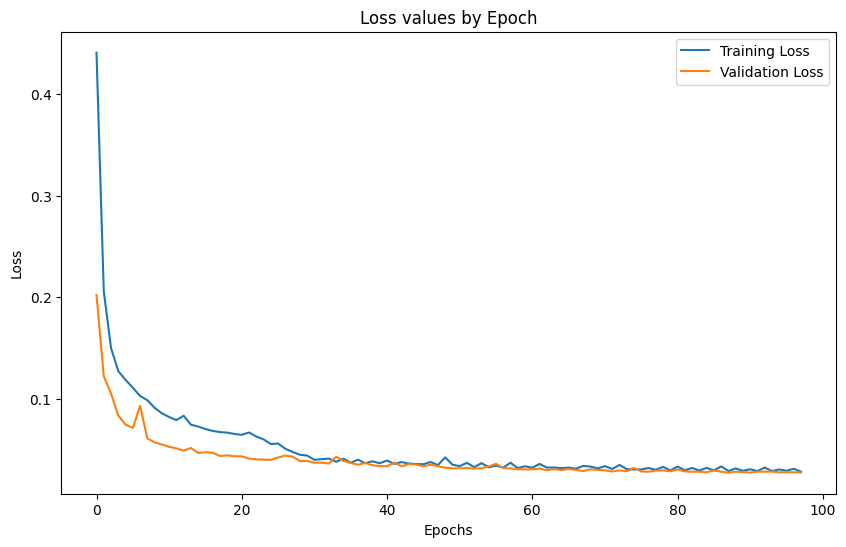

In [48]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

### ***Testing***

Given the trained model, we can now perform predicition on test dataset. We start with scaling test dataset based on MinMaxScaler fitted on train dataset. 

In [49]:
y_test = X_test['Label']
X_test.drop(['Label'], axis=1, inplace=True)
X_test_transformed = std_scaler.transform(X_test)

In [50]:
preds = autoencoder.predict(X_test_transformed)

15543/15543 [==============================] - 24s 2ms/step


In [ ]:
THRESHOLD = 0.05
mse = np.mean(np.power(X_test_transformed - preds, 2), axis=1)

recons_df = pd.DataFrame({
    'error': mse,
    'y_true': y_test.astype(bool)
}).reset_index(drop=True)

recons_df['y_pred'] = recons_df['error'] > THRESHOLD

In [91]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

       False       0.95      0.94      0.94    214938
        True       0.96      0.96      0.96    282408

    accuracy                           0.95    497346
   macro avg       0.95      0.95      0.95    497346
weighted avg       0.95      0.95      0.95    497346

